<a href="https://colab.research.google.com/github/Bolorooo24/CV-ML_labs/blob/main/Lab_2/Task_1/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# create simple CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, 3, 1)
        self.conv2 = nn.Conv2d(36, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# set the batch size
batch_size = 512

In [6]:
# load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.99MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# instantiate the model
model = Net().to(device)

In [8]:
# define the optimizer and loss funciton
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
# training loop
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
# evaluation function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

In [11]:
# training and evaluation loop
epochs = 4
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299979
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.109771

Test set: Average loss: 0.0001, Accuracy: 9790/10000 (97.90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.139861
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.086848

Test set: Average loss: 0.0001, Accuracy: 9851/10000 (98.51%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.059439
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.060163

Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.032389
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.057194

Test set: Average loss: 0.0001, Accuracy: 9876/10000 (98.76%)



In [12]:
# load and saved tstate dictionary
loaded_net = Net().to(device)
checkpoint = torch.load('mnist_cnn_model.pth')
loaded_net.load_state_dict(checkpoint)

<ipython-input-12-527d1c4db99e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mnist_cnn_model.pth')


<All keys matched successfully>

In [13]:
# define name of classes
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

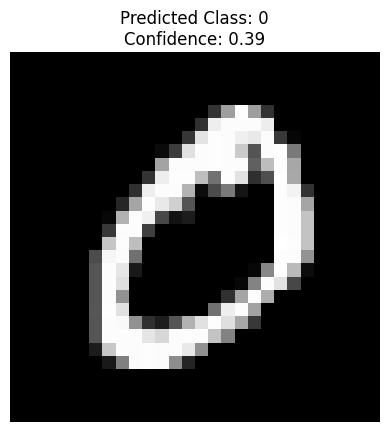

In [23]:

transform_for_model = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])


input_image = transform_for_model(image_np)
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)


with torch.no_grad():
    outputs = loaded_net(input_image)
    _, predicted = torch.max(outputs, 1)


predicted_class = classes[predicted.item()]
confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()


plt.imshow(image_np, cmap='gray')
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}')
plt.axis('off')
plt.show()
